# Email spam classification

### (a) Count of the number of ham and spam emails

In [ ]:
## Load Google Drive

# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:

import glob

ham_folder = glob.glob('/content/drive/My Drive/95865 Unstructured Data Analytics/HW3/email-data/ham/*.txt')
spam_folder = glob.glob('/content/drive/My Drive/95865 Unstructured Data Analytics/HW3/email-data/spam/*.txt')


In [ ]:
# construct a list of documents
spam_list = []
ham_list = []

for file in ham_folder:
  ham_list.append(file)

for file in spam_folder:
  spam_list.append(file)

print("Number of spam emails: " + str(len(spam_list)))
print("Number of ham emails: " + str(len(ham_list)))

Number of spam emails: 3671
Number of ham emails: 1500


**Dataset is imbalanced. There are more spam emails than ham emails (~2.5 : 1 ratio)**
In training the model it could be problematic in that the fitted classifier will be more naive and predict the majority class more often.

** One option to correct this imbalance, subsample randomly from the ham emails so as to have equal numbers of ham and spam emails in the training dataset**

### (b) Construct the documents [4 points]

   - Provided below is a function that returns a document present in a file given a fileName.
   - The function performs some preprocessing to (1) remove punctuation, (2),(3) remove whitespace and (4) lowercase all words.
   - Use this function to construct a list of documents.
   - Also construct a list of document labels containing `1` for spam and `0` for ham.

In [ ]:
import re
import string
import codecs

def makeWordList(path):

    with codecs.open(path, "r", encoding='utf-8', errors='ignore') as f:
        corpus_text = f.read()

    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  # -- (1)

    text = re.sub(r'\S*\d\S*','',corpus_text) # -- (2)
    text = re.sub(r'[^\w\s]','',text)         # -- (3)

    text = text.lower().split()           # -- (4)

    li = []
    for token in text:
        li.append(token)

    return " ".join(li)

In [ ]:
## construct list of documents
# construct a list of document labels containing 1 for spam and 0 for ham.

list_of_processed_documents = []
train_labels = []

for file in spam_folder:
  processed_file = makeWordList(file)
  list_of_processed_documents.append(processed_file)
  train_labels.append(1)

for file in ham_folder:
  processed_file = makeWordList(file)
  list_of_processed_documents.append(processed_file)
  train_labels.append(0)

In [ ]:
# check that 5171 files loaded
print(len(list_of_processed_documents))

# check that 5171 labels created
print(len(train_labels))

5171
5171


In [ ]:
train_labels = np.asarray(train_labels)

In [ ]:
#num_train_docs = X.shape[0]
#train_labels = list_of_labels
#len(train_labels)
train_labels.shape

(5171,)

### (c) Construct the document matrix `X` as a matrix of word frequencies [5 points]

   - Use the `CountVectorizer` from scikit-learn.
   - Set `min_df=50`; this drops words that don't occur in at least 50 documents.
   - Set `stop_words="english"` and `max_df=0.8` to filter out stop-words.
   - Print the size of the vocabulary (number of unique words)

In [ ]:
# create document matrix X

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words="english", max_df=0.8, min_df=50)


X = vectorizer.fit_transform(list_of_processed_documents)

print(X.shape)


(5171, 1680)


### (d) k-NN, SVM, random forest: Hyperparameter selection [20 points]

Now that you have your documents and labels as training data, you can perform 5-fold cross-validation to select the hyperparameters for different learning algorithms.

The hyperparameter with the best performance averaged across 5 folds is chosen. Use the **weighted F1-score** as the evaluation metric (i.e., for the `f1_score` function imported from `sklearn.metrics`, be sure to use the parameter `average='weighted'`).

   - k-NN: Select `k` from a range of values of your choice.
   - SVM: (SVC) Select `C` from a range of your choice, use any kernel that performs well.
   - Random forest: Select `n_estimators` **and** `max_depth` from a grid of your choice.

Store each chosen hyperparameter as `best_k`, `best_C`, `best_n_estimators`, and `best_max_depth` respectively.

Provided is some seed code for cross-validation that you may modify and reuse. Do not use the cross-validations score or grid-search functions from scikit-learn (you may use `KFold`).

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import numpy as np

In [ ]:
X_train = X.toarray()
X_train.shape

(5171, 1680)

In [ ]:
## KNN Hyperparameter selection

num_folds = 5
k_fold = KFold(num_folds, random_state = 0)
hyperparameter_settings = [2,5,10,50]
best_k = None
#best_f1_score = -np.inf
lowest_cross_val_error = -np.inf

for k in hyperparameter_settings:
  fold_scores=[]
  #for k,(train_indices,val_indices) in enumerate(k_fold.split(X_train,train_labels)):
  for train_indices,val_indices in k_fold.split(X_train,train_labels):
    classifier = KNeighborsClassifier(n_neighbors=k)
    #print(type(train_labels))
    classifier.fit(X_train[train_indices], train_labels[train_indices])
    predicted_val_labels = classifier.predict(X_train[val_indices])
    f1 = f1_score(train_labels[val_indices], predicted_val_labels, average='weighted')
    fold_scores.append(f1)

  cross_val_error = np.mean(fold_scores)
  print('k:', k, 'cross validation error:', cross_val_error)

  #if cross_val_error < lowest_cross_val_error:
  if cross_val_error > lowest_cross_val_error:
    lowest_cross_val_error = cross_val_error
    best_k = k

print('Best k:', best_k, 'cross validation error:', lowest_cross_val_error)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


k: 2 cross validation error: 0.9297496682936591


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


k: 5 cross validation error: 0.904168252173792


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


k: 10 cross validation error: 0.8858488652956898


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


k: 50 cross validation error: 0.8230141086405298
Best k: 2 cross validation error: 0.9297496682936591


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [ ]:
## SVM hyperparameter selection
from sklearn import svm

num_folds = 5
k_fold = KFold(num_folds, random_state = 0)
hyperparameter_settings = np.logspace(-4, 2, 5)
best_C = None

lowest_cross_val_error = -np.inf

for C in hyperparameter_settings:
  fold_scores=[]
  #for k,(train_indices,val_indices) in enumerate(k_fold.split(X_train,train_labels)):
  for train_indices, val_indices in k_fold.split(X_train,train_labels):
    classifier = svm.SVC(C=C, kernel='rbf')
    #print(type(train_labels))
    classifier.fit(X_train[train_indices], train_labels[train_indices])
    predicted_val_labels = classifier.predict(X_train[val_indices])
    f1 = f1_score(train_labels[val_indices], predicted_val_labels, average='weighted')
    fold_scores.append(f1)

  cross_val_error = np.mean(fold_scores)
  print('C:', C, 'cross validation error:', cross_val_error)

  #if cross_val_error < lowest_cross_val_error:
  if cross_val_error > lowest_cross_val_error:
    lowest_cross_val_error = cross_val_error
    best_C = C

print('Best C:', best_C)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default 

C: 0.0001 cross validation error: 0.677906485365247


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMet

C: 0.0031622776601683794 cross validation error: 0.677906485365247


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better f

C: 0.1 cross validation error: 0.7948286395415046


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true sample

C: 3.1622776601683795 cross validation error: 0.939872950763521


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning

C: 100.0 cross validation error: 0.9777339602056015
Best C: 100.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [ ]:
#Random forest hyperparameter selection

from sklearn.ensemble import RandomForestClassifier

num_folds = 5
k_fold = KFold(num_folds, random_state = 0)
hyperparameter_settings = [(num_trees, max_depth)
                           for num_trees in [10, 50, 200, 1000]
                           for max_depth in [3, 4, 5, None]]
best_n_estimators = None
best_max_depth = None

lowest_cross_val_error = -np.inf

for setting in hyperparameter_settings:
  fold_scores=[]
  num_trees, max_depth = setting
  for train_indices, val_indices in k_fold.split(X_train,train_labels):
    classifier = RandomForestClassifier(n_estimators=num_trees,
                                            max_depth=max_depth,
                                            random_state=0)
    classifier.fit(X_train[train_indices], train_labels[train_indices])
    predicted_val_labels = classifier.predict(X_train[val_indices])
    f1 = f1_score(train_labels[val_indices], predicted_val_labels, average='weighted')
    fold_scores.append(f1)

  cross_val_error = np.mean(fold_scores)
  print('C:', C, 'cross validation error:', cross_val_error)

  #if cross_val_error < lowest_cross_val_error:
  if cross_val_error > lowest_cross_val_error:
    lowest_cross_val_error = cross_val_error
    best_n_estimators, best_max_depth = setting

print('Best num estimators:', best_n_estimators)
print('Best max depth:', best_max_depth)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


C: 100.0 cross validation error: 0.8403564869292944


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


C: 100.0 cross validation error: 0.8526922833024816


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


C: 100.0 cross validation error: 0.8699491037727972


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


C: 100.0 cross validation error: 0.9674006901880032


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


C: 100.0 cross validation error: 0.8327419825848865


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


C: 100.0 cross validation error: 0.8454210132094394


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


C: 100.0 cross validation error: 0.8597498887383119


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


C: 100.0 cross validation error: 0.9766663645442172


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


C: 100.0 cross validation error: 0.8165525954073484


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


C: 100.0 cross validation error: 0.8379948436027862


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


C: 100.0 cross validation error: 0.8542963577994952


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


C: 100.0 cross validation error: 0.9776084533664651


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


C: 100.0 cross validation error: 0.8138291830337219


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


C: 100.0 cross validation error: 0.836477493168443


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


C: 100.0 cross validation error: 0.8549898434108449


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


C: 100.0 cross validation error: 0.9779358633872132
Best num estimators: 1000
Best max depth: None


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### (e) Classifier testing: Precision-Recall and ROC curves [20 points]

   - Use the best hyperparameters for each classifier from the previous question to **train** your classifiers on the training data.
   - Use test emails to in the `testing` folder to **test** your classifiers and construct the plots below.

Things to plot:

   - Construct one plot containing 3 ROC curves, one for each classifier.
   - In the legend of this plot, display the AUC for each classifier.
   - Construct one plot containing 3 precision-recall curves, one for each classifier.
   - In the legend of each plot, display the average precision for each classifier.

Note that these plots are on the test data: you will have to read in this data, construct a document matrix and labels. Some words in the test data may not have been present in the training data: there are multiple ways to address this, briefly describe your approach.

Things to answer:

   - Of the ROC and Precision-Recall curves, which one would you use for this task and why?
   - Which classifier is the best, according to your chosen curves?

In [ ]:
# construct document matrix for test data

ham = glob.glob('/content/drive/My Drive/95865 Unstructured Data Analytics/HW3/email-data/testing/*.ham.txt')
spam = glob.glob('/content/drive/My Drive/95865 Unstructured Data Analytics/HW3/email-data/testing/*.spam.txt')

In [ ]:
spam_test = []
ham_test = []

for file in ham:
  ham_test.append(file)

for file in spam:
  spam_test.append(file)

print("Number of spam emails: " + str(len(spam_test)))
print("Number of ham emails: " + str(len(ham_test)))

Number of spam emails: 49
Number of ham emails: 51


In [ ]:
##
test_documents = []
test_labels = []

for file in spam_test:
  processed_file = makeWordList(file)
  test_documents.append(processed_file)
  test_labels.append(1)

for file in ham_test:
  processed_file = makeWordList(file)
  test_documents.append(processed_file)
  test_labels.append(0)

In [ ]:
test_labels = np.asarray(test_labels)
#test_vectorizer = CountVectorizer(stop_words="english", max_df=0.8, min_df=50)
x_test = vectorizer.transform(test_documents)


In [ ]:
print(x_test.shape)

(100, 1680)


In [ ]:
X_test = x_test.toarray()
#print(X_test.shape)

In [ ]:
# Train KNN model using selected hyperparameters
knn_classifier = KNeighborsClassifier(n_neighbors=best_k)
knn_classifier.fit(X_train, train_labels)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')

In [ ]:
# Train SVM model using selected hyperparameters
svm_classifier = svm.SVC(kernel='rbf', C=best_C)
svm_classifier.fit(X_train, train_labels)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [ ]:
# Train RandomForest model using selected hyperparameters
rf_classifier = RandomForestClassifier(n_estimators=best_n_estimators,
                                       max_depth=best_max_depth,
                                       random_state=0)
rf_classifier.fit(X_train, train_labels)



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [ ]:
# Test classifiers and plot
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

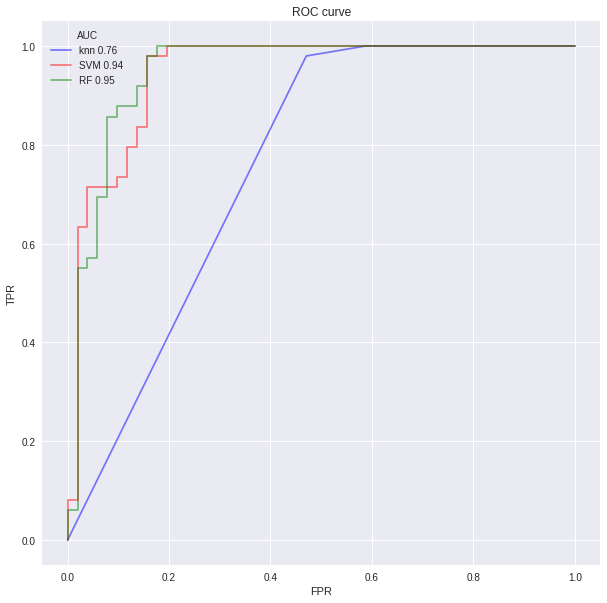

In [ ]:
plt.figure(figsize=(10,10))

knn_predicted = knn_classifier.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(test_labels, knn_predicted, pos_label=1)
auc = np.trapz(tpr, fpr)
plt.plot(fpr, tpr, linestyle='-', alpha=0.5, color= 'blue',
         label = 'knn ' + str("%.2f" % round(auc,2)))

svm_predicted = svm_classifier.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(test_labels, svm_predicted, pos_label=1)
auc = np.trapz(tpr, fpr)
plt.plot(fpr, tpr, linestyle='-', alpha=0.5, color= 'red',
         label = 'SVM ' + str("%.2f" % round(auc,2)))

rf_predicted = rf_classifier.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(test_labels, rf_predicted, pos_label=1)
auc = np.trapz(tpr, fpr)
plt.plot(fpr, tpr, linestyle='-', alpha=0.5, color= 'green',
         label = 'RF ' + str("%.2f" % round(auc,2)))

plt.legend(title = 'AUC', loc = 'best')
plt.title("ROC curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

Text(0, 0.5, 'Precision')

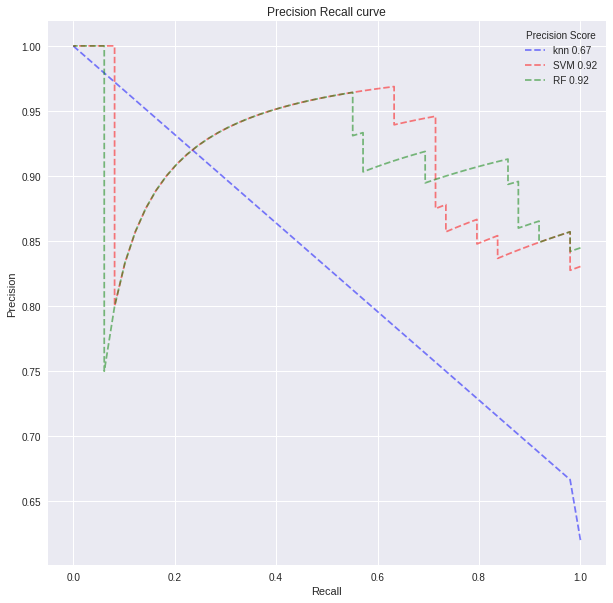

In [ ]:
plt.figure(figsize=(10,10))

knn_predicted = knn_classifier.predict_proba(X_test)[:,1]
precision, recall, _  = precision_recall_curve(test_labels, knn_predicted)
#precision, recall, _  = precision_recall_curve(test_labels, knn_predicted, pos_label=1)
auPR = average_precision_score(test_labels, knn_predicted)
plt.plot(recall, precision, linestyle='--', alpha=0.5, color= 'blue',
         label = 'knn ' + str("%.2f" % round(auPR,2)))


svm_predicted = svm_classifier.decision_function(X_test)
precision, recall, _  = precision_recall_curve(test_labels, svm_predicted)
auPR = average_precision_score(test_labels, svm_predicted)
plt.plot(recall, precision, linestyle='--', alpha=0.5, color= 'red',
         label = 'SVM ' + str("%.2f" % round(auPR,2)))

rf_predicted = rf_classifier.predict_proba(X_test)[:,1]
precision, recall, _  = precision_recall_curve(test_labels, rf_predicted)
auPR = average_precision_score(test_labels, rf_predicted)
plt.plot(recall, precision, linestyle='--', alpha=0.5, color= 'green',
         label = 'RF ' + str("%.2f" % round(auPR,2)))


plt.legend(title = 'Precision Score', loc = 'best')
plt.title("Precision Recall curve")
plt.xlabel('Recall')
plt.ylabel('Precision')
#plt.show()

* Some words in the test data may not have been present in the training data: there are multiple ways to address this, briefly describe your approach.

**My approach was to transform test_documents using CountVectorizer I had fit unto training documents. Therefore model was not learning vocabulary that was not in training set. The document-term matrix that is returned would therefore exclude test data not present in training data**

* Of the ROC and Precision-Recall curves, which one would you use for this task and why?

**For spam email classficiation, we care more about correctly predicting true positives so a precision-recall curve would be more instructive.**


* Which classifier is the best, according to your chosen curves?

Random forest classifier and SVM classifier perform equally well based on ROC and Precision-Recall curves
